In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vipulparmar30","key":"c28062a66f440a20a28f22a15152e0df"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:
base_dir ='/content/drive/MyDrive/chest_xray/chest_xray'
train_dir = base_dir + '/train'
validation_dir = base_dir + '/val'
test_dir = base_dir + '/test'

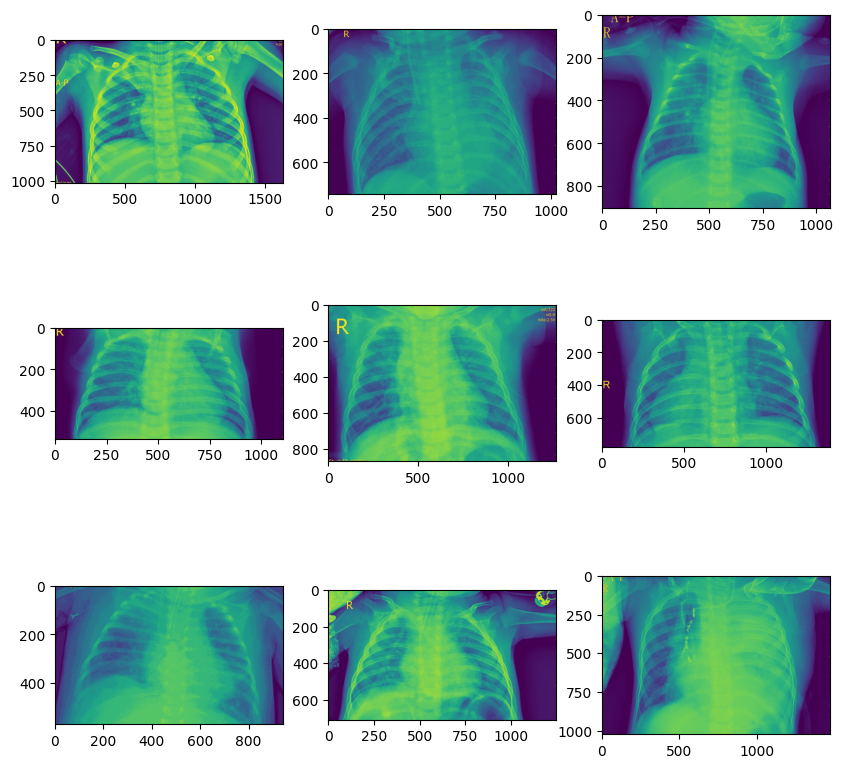

In [ ]:
pneumonia_dir= os.path.join(train_dir, 'PNEUMONIA')
images= os.listdir(pneumonia_dir)
plt.figure(figsize=(10,10))

for i in range(9):
  img_path= os.path.join(pneumonia_dir, random.choice(images))
  img= mpimg.imread(img_path)
  plt.subplot(3,3,i+1)
  plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

transform= transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset= ImageFolder(train_dir, transform=transform)
validation_dataset= ImageFolder(validation_dir, transform=transform)
test_dataset= ImageFolder(test_dir, transform=transform)

#dataloader

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dataloader= DataLoader(validation_dataset,batch_size=32)
test_dataloader = DataLoader(test_dataset,batch_size=32)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flattend_size = self._get_flattend_size()  # ✅ Auto-calculate flatten size

    self.fc1 = nn.Linear(in_features=self.flattend_size, out_features=128)  # ✅ Use it here
    self.fc2 = nn.Linear(in_features=128, out_features=2)

  def _get_flattend_size(self):
    with torch.no_grad():
      dummy_input = torch.randn(1, 1, 224, 224)  # Same shape as real input
      x = self.pool(F.relu(self.conv1(dummy_input)))
      x = self.pool2(F.relu(self.conv2(x)))
      return x.view(-1).shape[0]  # Return flatten size

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/chest_xray/simple_cnn_chest.pth")

In [ ]:
model=SimpleCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/chest_xray/simple_cnn_chest.pth'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits

    def forward(self,inputs,targets):
      ce_loss = F.cross_entropy(inputs, targets, reduction='none')
      pt=torch.exp(-ce_loss)
      focal_weight = (1 - pt) ** self.gamma
      focal_loss = focal_weight * ce_loss
      return focal_loss.mean()

In [ ]:
import numpy as np
import torch.nn as nn
train_normal = 1341
train_pneumonia = 3875
total = train_normal + train_pneumonia

# Compute weights
weight_normal = total / (2 * train_normal)
weight_pneumonia = total / (2 * train_pneumonia)

# Create weight tensor
class_weights = torch.tensor([weight_normal, weight_pneumonia], dtype=torch.float)


model=SimpleCNN()
criterion=FocalLoss(alpha=[weight_normal,weight_pneumonia],gamma=2.0)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

num_epoch=100
best_val_loss=float('inf')
threshold=5
trigger_times=0

for epoch in range(num_epoch):
  running_loss=0.00
  correct=0.00
  total=0.00

  model.train()

  for(inputs,labels) in train_dataloader:
    inputs,labels = inputs.to(device),labels.to(device)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()
  epoch_accuracy = correct / total
  epoch_loss = running_loss / len(train_dataloader)
  print(f"Epoch [{epoch+1}/num_epoch],Loss :{epoch_loss:.4f} , Accuracy:{epoch_accuracy:.2f}")

  model.eval()
  val_loss=0.0
  val_correct=0
  val_total=0

  with torch.no_grad():
    for(inputs,labels) in validation_dataloader:
      inputs,labels=inputs.to(device),labels.to(device)
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      val_loss+=loss.item()
      _,predicted=torch.max(outputs.data,1)
      val_total+=labels.size(0)
      val_correct+=(predicted==labels).sum().item()
  val_accuracy= val_correct/val_total
  val_loss=val_loss/len(validation_dataloader)
  print(f"Validation Loss:{val_loss:.4f},Validation Accuracy:{val_accuracy:.2f}")
  if val_loss<best_val_loss:
    best_val_loss=val_loss
    trigger_times=0
    torch.save(model.state_dict(),'/content/drive/MyDrive/chest_xray/simple_cnn_chest.pth')
  else:
    trigger_times+=1
    if trigger_times>=threshold:
      print("Early stopping triggered")
      break

Epoch [1/num_epoch],Loss :0.1021 , Accuracy:0.89
Validation Loss:0.1024,Validation Accuracy:0.88
Epoch [2/num_epoch],Loss :0.0235 , Accuracy:0.97
Validation Loss:0.0652,Validation Accuracy:0.88
Epoch [3/num_epoch],Loss :0.0209 , Accuracy:0.97
Validation Loss:0.1160,Validation Accuracy:0.81
Epoch [4/num_epoch],Loss :0.0144 , Accuracy:0.98
Validation Loss:0.0445,Validation Accuracy:0.94
Epoch [5/num_epoch],Loss :0.0146 , Accuracy:0.98
Validation Loss:0.0744,Validation Accuracy:0.88
Epoch [6/num_epoch],Loss :0.0106 , Accuracy:0.98
Validation Loss:0.0251,Validation Accuracy:1.00
Epoch [7/num_epoch],Loss :0.0089 , Accuracy:0.99
Validation Loss:0.0059,Validation Accuracy:1.00
Epoch [8/num_epoch],Loss :0.0044 , Accuracy:0.99
Validation Loss:0.0258,Validation Accuracy:0.94
Epoch [9/num_epoch],Loss :0.0016 , Accuracy:1.00
Validation Loss:0.0379,Validation Accuracy:0.94
Epoch [10/num_epoch],Loss :0.0014 , Accuracy:1.00
Validation Loss:0.0622,Validation Accuracy:0.94
Epoch [11/num_epoch],Loss :0.

In [ ]:
#Grad-CAM (Gradient weightage Class Activation Mapping) part
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import cv2
gradcam_pneumonia_pth = "/content/drive/MyDrive/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"  # example path
gradcam_pneumonia_img = Image.open(gradcam_pneumonia_pth).convert('L')  # Grayscale


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Assuming grayscale normalization
])

input_tensor = transform(gradcam_pneumonia_img).unsqueeze(0)  # Add batch dim
input_tensor = input_tensor.to(device)      # Send to GPU/CPU

inputs = input_tensor

target_layer=model.conv2 #Latest layer so that it captures the high level features

gradients= None
activations= None
def forward_hook(module, input, output):
    global activations
    activations = output.detach()
def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()

forward_handle = model.conv2.register_forward_hook(forward_hook)
backward_handle = model.conv2.register_backward_hook(backward_hook)

output = model(inputs)

pred_class = output.argmax(dim=1).item()
print("Predicted class:", pred_class)

model.zero_grad()
output[0, pred_class].backward()

gradients_np = gradients.cpu().numpy()
activations_np = activations.cpu().numpy()

weights = np.mean(gradients_np[0], axis=(1, 2)) #avg pooling

grad_cam = np.zeros(activations_np.shape[2:], dtype=np.float32)

for i, w in enumerate(weights):
    grad_cam += w * activations_np[0,i]
grad_cam = np.maximum(grad_cam, 0)

img_np = np.array(gradcam_pneumonia_img.resize((224, 224)))  # ensure same size as heatmap
img_color = np.stack([img_np]*3, axis=-1)  # convert grayscale to RGB shape

grad_cam = grad_cam.squeeze()
grad_cam -= grad_cam.min()
grad_cam /= grad_cam.max()
grad_cam_resized = cv2.resize(grad_cam, (224, 224))
grad_cam_uint8 = np.uint8(255 * grad_cam_resized)
heatmap = cv2.applyColorMap(grad_cam_uint8, cv2.COLORMAP_JET)

superimposed_img = np.uint8(heatmap * 0.4 + img_color * 0.6)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class: 1


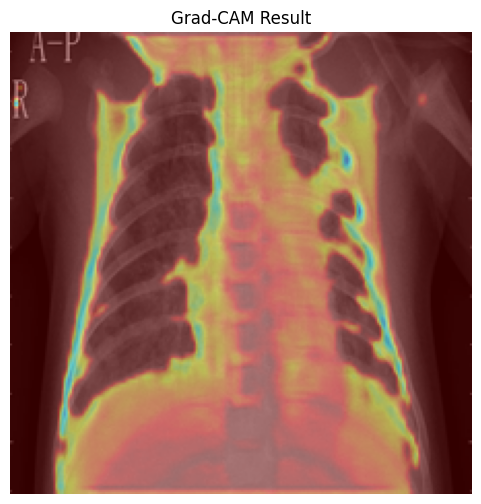

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(superimposed_img.astype(np.uint8))
plt.axis('off')
plt.title("Grad-CAM Result")
plt.show()


In [ ]:
#Grad-CAM (Gradient weightage Class Activation Mapping) part
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import cv2
gradcam_normal_pth = "/content/drive/MyDrive/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg"  # example path
gradcam_normal_img = Image.open(gradcam_normal_pth).convert('L')  # Grayscale


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Assuming grayscale normalization
])

input_tensor = transform(gradcam_normal_img).unsqueeze(0)  # Add batch dim
input_tensor = input_tensor.to(device)      # Send to GPU/CPU

inputs = input_tensor

target_layer=model.conv2 #Latest layer so that it captures the high level features

gradients= None
activations= None
def forward_hook(module, input, output):
    global activations
    activations = output.detach()
def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()

forward_handle = model.conv2.register_forward_hook(forward_hook)
backward_handle = model.conv2.register_backward_hook(backward_hook)

output = model(inputs)

pred_class = output.argmax(dim=1).item()
print("Predicted class:", pred_class)

model.zero_grad()
output[0, pred_class].backward()

gradients_np = gradients.cpu().numpy()
activations_np = activations.cpu().numpy()

weights = np.mean(gradients_np[0], axis=(1, 2)) #avg pooling

grad_cam = np.zeros(activations_np.shape[2:], dtype=np.float32)

for i, w in enumerate(weights):
    grad_cam += w * activations_np[0,i]
grad_cam = np.maximum(grad_cam, 0)

img_np = np.array(gradcam_normal_img.resize((224, 224)))  # ensure same size as heatmap
img_color = np.stack([img_np]*3, axis=-1)  # convert grayscale to RGB shape

grad_cam = grad_cam.squeeze()
grad_cam -= grad_cam.min()
grad_cam /= grad_cam.max()
grad_cam_resized = cv2.resize(grad_cam, (224, 224))
grad_cam_uint8 = np.uint8(255 * grad_cam_resized)
heatmap = cv2.applyColorMap(grad_cam_uint8, cv2.COLORMAP_JET)

superimposed_img = np.uint8(heatmap * 0.4 + img_color * 0.6)


Predicted class: 0


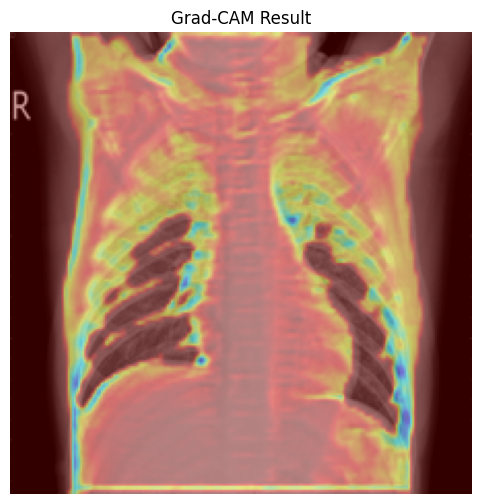

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(superimposed_img.astype(np.uint8))
plt.axis('off')
plt.title("Grad-CAM Result")
plt.show()


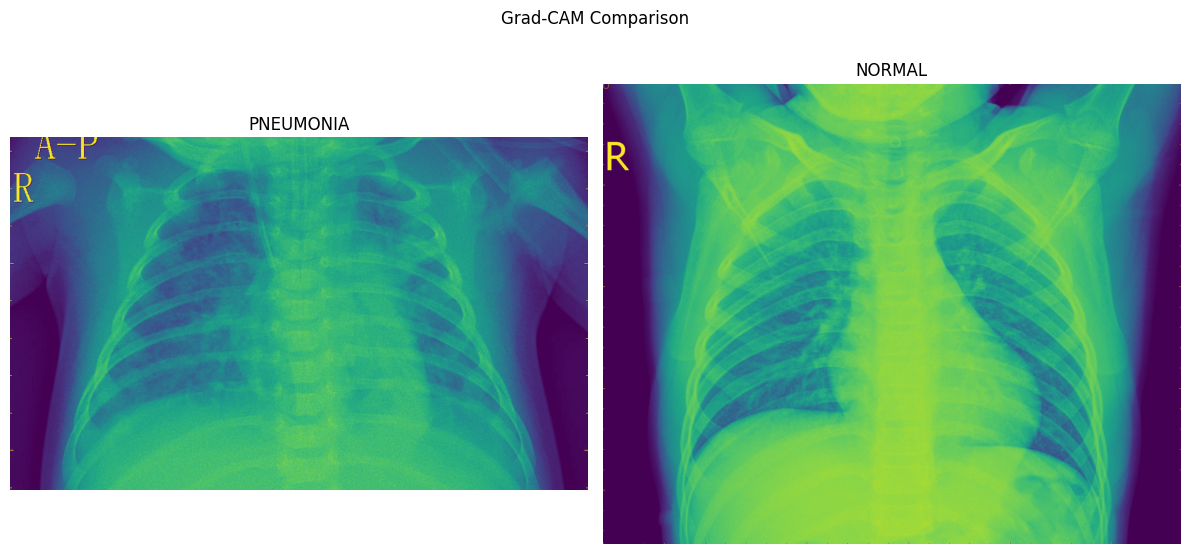

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(gradcam_pneumonia_img)
ax[0].axis('off')
ax[0].set_title("PNEUMONIA")

ax[1].imshow(gradcam_normal_img)
ax[1].axis('off')
ax[1].set_title("NORMAL")

plt.suptitle("Grad-CAM Comparison")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=['NORMAL','PNEUMONIA']))


Accuracy: 0.7387820512820513
              precision    recall  f1-score   support

      NORMAL       0.96      0.32      0.48       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.83      0.65      0.65       624
weighted avg       0.80      0.74      0.69       624



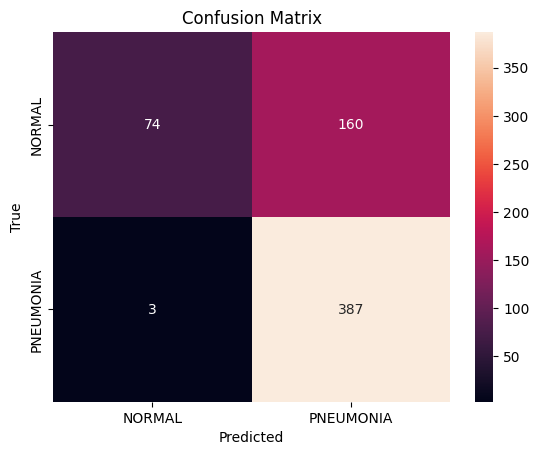

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NORMAL','PNEUMONIA'], yticklabels=['NORMAL','PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os

train_normal = len(os.listdir('/content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL'))
train_pneumonia = len(os.listdir('/content/drive/MyDrive/chest_xray/chest_xray/train/PNEUMONIA'))

val_normal = len(os.listdir('/content/drive/MyDrive/chest_xray/chest_xray/val/NORMAL'))
val_pneumonia = len(os.listdir('/content/drive/MyDrive/chest_xray/chest_xray/val/PNEUMONIA'))

test_normal = len(os.listdir('/content/drive/MyDrive/chest_xray/chest_xray/test/NORMAL'))
test_pneumonia = len(os.listdir('/content/drive/MyDrive/chest_xray/chest_xray/test/PNEUMONIA'))

print("Train NORMAL:", train_normal)
print("Train PNEUMONIA:", train_pneumonia)
print("Val NORMAL:", val_normal)
print("Val PNEUMONIA:", val_pneumonia)
print("Test NORMAL:", test_normal)
print("Test PNEUMONIA:", test_pneumonia)


Train NORMAL: 1341
Train PNEUMONIA: 3875
Val NORMAL: 8
Val PNEUMONIA: 8
Test NORMAL: 234
Test PNEUMONIA: 390


In [ ]:
normal_count=len(os.listdir('/content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL'))
pneumonia_count=len(os.listdir('/content/drive/MyDrive/chest_xray/chest_xray/train/PNEUMONIA'))
total_images= normal_count + pneumonia_count

weight_normal     = total_images / (2 * normal_count)
weight_pneumonia  = total_images / (2 * pneumonia_count)

print(f"Weight NORMAL:     {weight_normal:.3f}")
print(f"Weight PNEUMONIA:  {weight_pneumonia:.3f}")

import torch
import torch.nn as nn

class_weights = torch.tensor(
    [weight_normal, weight_pneumonia],  # index 0 → NORMAL, index 1 → PNEUMONIA
    dtype=torch.float32
).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights)
